# DAY 7: Neural networks for classification

### Machine Learning and Computational Statistics (DSC6232)

Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

Due: August 2nd, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. train a neural network for classification
2. diagnose training performance of a NN using the traceplot
3. compare classifiers using the ROC curve and AUC


### Import necessary libraries

In [ ]:
import numbers
#import libraries for implementing neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
#import sklearn packages
import sklearn
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, plot_roc_curve, accuracy_score
#import libraries of data manipulation, matrix operations and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Auxiliary functions to generate and visualize data.
**No need to read through!**

In [ ]:
def scatter_plot_data(x, y, ax, limit=None):
    '''
    scatter_plot_data scatter plots the patient data. A point in the plot is colored 'red' if cancerous 
    and blue otherwise.
    
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       ax - axis to plot on
    returns: 
       ax - the axis with the scatter plot
    '''
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    if limit is None:
      ax.set_xlim((-2.5, 2.5))
      ax.set_ylim((-2.5, 2.5))     
    else:
      ax.set_xlim(limit)
      ax.set_ylim(limit)     
    ax.legend(loc='best')
    return ax

def plot_decision_boundary(x, y, model, ax, limit=None, poly_degree=1, threshold=0.5):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       model - the 'sklearn' classification model
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       threshold - the classification threshold
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.4, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.4, c='blue', label='class 0')
    
    # Create mesh
    if limit is None:
      interval = np.arange(-2.5, 2.5, 0.01)
    else:
      interval = np.arange(limit[0], limit[1], 0.05)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree)
        xx = polynomial_features.fit_transform(xx)
    if threshold != 0.5:
      if isinstance(model.predict(xx)[0], float):
        yy_prob = model.predict_proba(xx)[:, 1]
        yy = yy_prob
      else:
        yy_prob = model.predict(xx)
        yy = yy_prob
      yy[yy_prob >= threshold] = 1
      yy[yy_prob < threshold] = 0
    else:
      yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='bwr')
    ax.contour(x1, x2, yy, levels=[0.5], colors='black', linewidths=0.4)
    ax.set_xlabel('marker 1')
    ax.set_ylabel('marker 2')
    if limit is None:
      ax.set_xlim((-2.5, 2.5))
      ax.set_ylim((-2.5, 2.5))     
    else:
      ax.set_xlim(limit)
      ax.set_ylim(limit)  
    ax.legend(loc='best')
    return ax

def make_unbalanced_moons(n_samples=100, p=0.2, shuffle=True, noise=None, random_state=None):
    if isinstance(n_samples, numbers.Integral):
        n_samples_out = int(n_samples * p)
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError:
            raise ValueError('`n_samples` can be either an int or '
                             'a two-element tuple.')

    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - .5

    X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y)]).T
    y = np.hstack([np.zeros(n_samples_out, dtype=np.intp),
                   np.ones(n_samples_in, dtype=np.intp)])

    if shuffle:
        X, y = sklearn.utils.shuffle(X, y)

    if noise is not None:
        X += np.random.normal(scale=noise, size=X.shape)

    return X, y

## Let us generate data for classification:

We generate toy data for this application. $x$ is a an array where each row represents an input/observation and each column represents a marker. $y$ is an array of 0's and 1's, where 0 indicates class 0, and 1 indicates class 1.

**Instructions**: run the code below to make a toy training and testing classification data set and visualize the data.

In [ ]:
# Dataset: generate a toy classification data set with non-linear decision boundary
X, Y = make_unbalanced_moons(noise=0.35, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

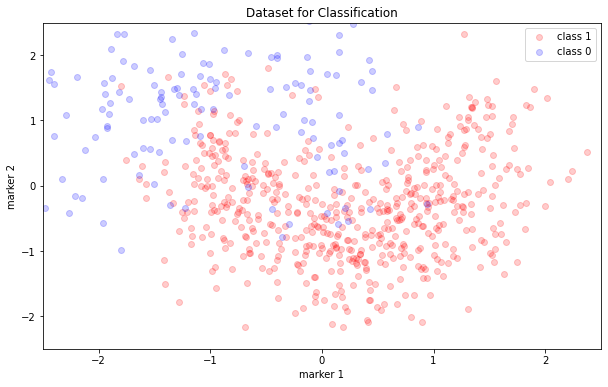

In [ ]:
# Visualize Dataset
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
scatter_plot_data(X_train, Y_train, ax)
ax.set_title('Dataset for Classification')
plt.show()

**Exercise 1:** What do you notice about this data set that can potentially cause problems for a classifier?

## 1. Fit a Logistic Regression Model

**Exercise 2:** Train a logistic regression on this data. Visualize the classification boundary of the model, and compute your model's confusion matrix, ROC curve and AUC. 


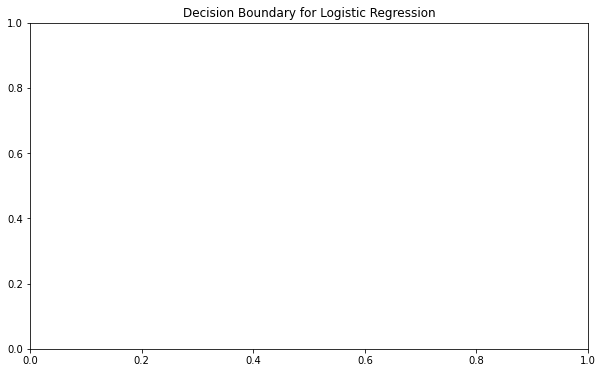

In [ ]:
# Step 1. Fit a logistic regression 
# COMPLETE

# Step 2. Visualize the decision boundary
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#plot_decision_boundary(X_train, Y_train, logistic_regression, ax)
ax.set_title('Decision Boundary for Logistic Regression')
plt.show()

In [ ]:
### Evaluate the training and testing performance of your model 
# Step 1: Predict using your model
# COMPLETE
# Y_predict = ...

# Step 2: Compute test accuracy
# COMPLETE
# test_accuracy = ...
# print('Test accuracy:', test_accuracy)

# Step 3: Compute the test confusion matrix
# COMPLETE
# matrix = ...
# print('Confusion matrix for the classification on test:\n', matrix)

In [ ]:
# Step 4: Plot the ROC curve
# Hint: see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html
# COMPLETE
plt.show()

**Exercise 3:** Looking at your model's classification boundary, how well does your model fit the data? What are the shortcomings of your model?

**Exercise 4:** Looking at your confusion matrix, what are the model's False Positive Rate and False Negative Rate?

**Exercise 4:** Looking at the plot of the ROC curve, what threshold would you choose for your classifier? How does this choice affect the False Positive Rates? How does this choice affect the False Negative Rates?

**Exercise 5:** Change the classification threshold to the optimal one you selected in Exercise 4. Visualize the new decision boundary. Compute the confusion matrix using the new threshold. How does the new confusion matrix compared with the one computed in Exercise 2?


In [ ]:
# Step 1: compute the probability of being in each class
#Y_probability = logistic_regression.predict_proba(X_test)

# Step 2: the returned array has two columns: 
# one for the probability of class 0 and one for the probability of class 1. 
# Since this is a binary classification problem, we only care about the probability
# of being in class 1 or not. Thus, we take the 1st column as follows:
#Y_probability = Y_probability[:, 1]

# Step 3: set a threshold
#threshold = ...

## Step 4: classify as '1' when the probability is bigger than the threshold
## other, set the probability to 0
#Y_predict = Y_probability
#Y_predict[Y_probability >= threshold] = 1
#Y_predict[Y_probability < threshold] = 0

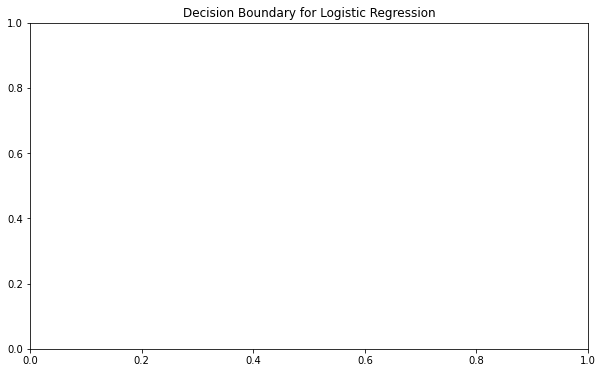

In [ ]:
# Step 5: visualize the new decision boundary with your new classification threshold!
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#plot_decision_boundary(X_train, Y_train, logistic_regression, ax, threshold=threshold)
ax.set_title('Decision Boundary for Logistic Regression')
plt.show()

In [ ]:
# Step 6: Compute the test confusion matrix
# matrix = ...
# print('Confusion matrix for the classification on test:\n', matrix)

## 2. Fit a Neural Network Classifier

**Exercise 5:** Fit a neural network classifier. Find the best architecture and regularization strength for this dataset.
Visualize the training data as well as the decision boundary.
How well does the model fit the data?

In [ ]:
# Step 1: Choose settings for the neural network
H = 10 # number of hidden nodes
input_dim = X_train.shape[1] # input dimension
reg = l2(0.01) # change the strength of the regularizer

# Step 2: Create neural network
model = Sequential()
model.add(Dense(H, input_dim=input_dim, activation='tanh', kernel_regularizer=reg, bias_regularizer=reg)) # input layer
model.add(Dense(H, activation='tanh', kernel_regularizer=reg, bias_regularizer=reg)) # hidden layer 1
model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg, bias_regularizer=reg)) # output layer

# Step 3: Configure the model
learning_rate = 0.001
sgd = SGD(lr=learning_rate)
model.compile(optimizer=sgd, loss='binary_crossentropy')

In [ ]:
# Step 4: Fit the model
history = model.fit(X_train, Y_train, batch_size=200, epochs=500, verbose=0)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


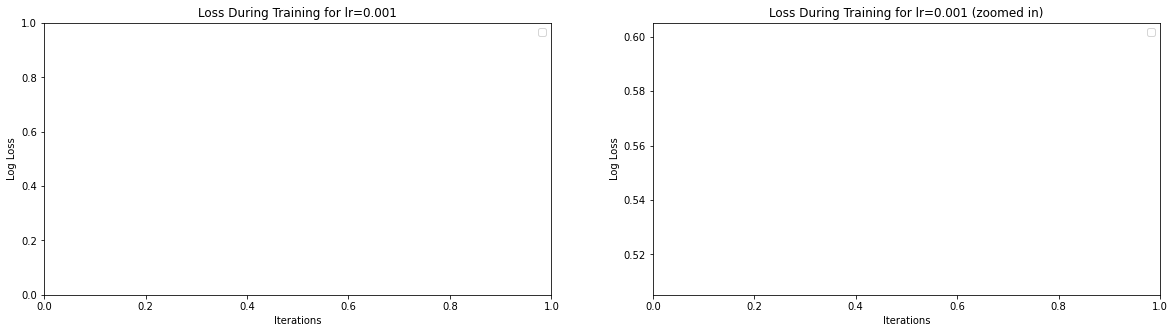

In [ ]:
# Step 5: Visualize the trace of loss function
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Visualize the training trajectory
#ax[0].plot(np.array(history.history['loss']), color='red', label='training loss')
ax[0].legend(loc="best")
ax[0].set_title("Loss During Training for lr={}".format(learning_rate))
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Log Loss")

# Visualize the training trajectory (zoomed in)
#ax[1].plot(np.array(history.history['loss']), color='red', label='training loss')
ax[1].legend(loc="best")
ax[1].set_title("Loss During Training for lr={} (zoomed in)".format(learning_rate))
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Log Loss")
ax[1].set_ylim((np.min(np.array(history.history['loss'])), np.min(np.array(history.history['loss']) + 0.1)))
plt.show()

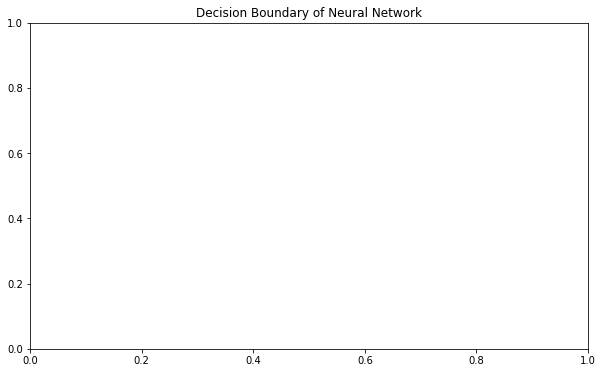

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Step 6: Visualize decision boundary
#plot_decision_boundary(X_train, Y_train, model, ax)
ax.set_title('Decision Boundary of Neural Network')
plt.show()

**Exercise 6:** Compute the confusion matrix, the AUC and plot the ROC curve. Based on these metrics how well is your model doing?

In [ ]:
### Evaluate the training and testing performance of your model 
# Step 1: Predict labels using your model (use the method predict_classes: https://kite.com/python/docs/tensorflow.keras.Sequential.predict_classes)
# COMPLETE

# Step 2: Compute the test confusion matrix
# COMPLETE
# print('Confusion matrix for the classification on test:\n', matrix)

No handles with labels found to put in legend.


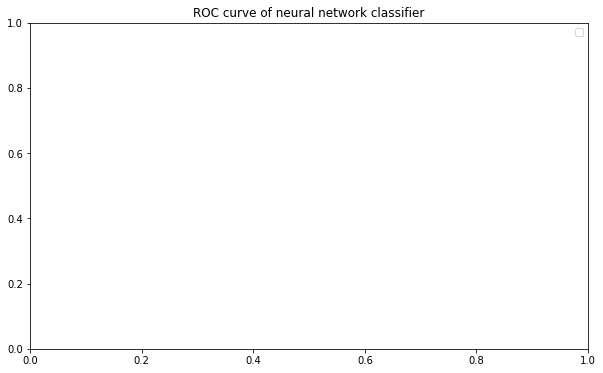

In [ ]:
# Step 4: Compute the ROC curve using roc_curve, this returns the false positive rate, true positive rate and thresholds
# Hint: check documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# COMPLETE

# Step 5: Visualize the ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.plot(fpr, tpr, label='ROC curve')
ax.legend(loc='best')
ax.set_title('ROC curve of neural network classifier')
plt.show()

**Exercise 7:** Change the classification threshold to the optimal one using the ROC curve. Visualize the new decision boundary. Compute the confusion matrix using the new threshold. How does the new confusion matrix compared with the one computed in Exercise 2?

In [ ]:
# Step 2: compute the probability of being in each class
# COMPLETE

# Step 3: set a threshold
# COMPLETE
#threshold = ...

# Step 4: classify as '1' when the probability is bigger than the threshold
# other, set the probability to 0
# COMPLETE

# Step 5: Compute the accuracy (Hint: use accuracy_score method)
# COMPLETE
#test_accuracy = ... 
#print('Test Accuracy:', test_accuracy)

# Step 6: Compute the test confusion matrix
# COMPLETE
# print('Confusion matrix for the classification on test:\n', matrix)

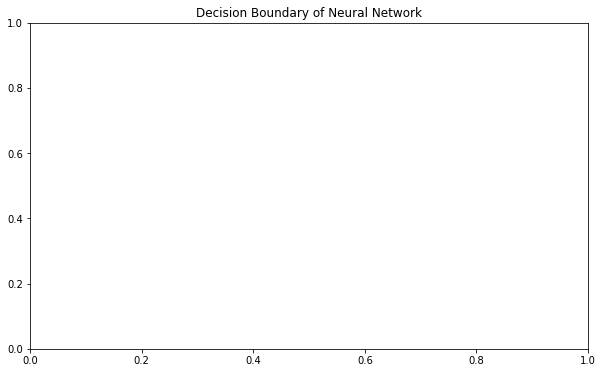

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Step 1: Visualize decision boudnary
#plot_decision_boundary(X_train, Y_train, model, ax, threshold=0.5)
ax.set_title('Decision Boundary of Neural Network')
plt.show()